In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.optim.lr_scheduler import StepLR
import torchvision
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tarfile
import os
import csv
import shutil

In [2]:
# Download Oxford 17 Category Flower Dataset
!wget http://www.robots.ox.ac.uk/~vgg/data/flowers/17/17flowers.tgz -O 17flowers.tgz

--2022-10-28 15:12:48--  http://www.robots.ox.ac.uk/~vgg/data/flowers/17/17flowers.tgz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~vgg/data/flowers/17/17flowers.tgz [following]
--2022-10-28 15:12:49--  https://www.robots.ox.ac.uk/~vgg/data/flowers/17/17flowers.tgz
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 60270631 (57M) [application/x-gzip]
Saving to: ‘17flowers.tgz’

17flowers.tgz       100%[===================>]  57.48M  11.4MB/s    in 6.4s    

2022-10-28 15:12:56 (9.03 MB/s) - ‘17flowers.tgz’ saved [60270631/60270631]



In [3]:
# Split the images in ./jpg into 17 folders
!cd ./jpg && for i in {1..17}; do mkdir $i; done


/bin/bash: line 0: cd: ./jpg: No such file or directory


In [4]:
# Move image_xxxx.jpg to folder (((xxxx-1)//80) + 1)
!cd ./jpg && for i in {0001..1360}; do mv "image_$i.jpg" $(((i-1)/80 + 1)); done

/bin/bash: line 0: cd: ./jpg: No such file or directory


In [5]:
file = tarfile.open("17flowers.tgz")
file.extractall("data_flowers/")
dir = "data_flowers/jpg/"
arr = os.listdir(dir)

# uncomment this if you just download a new flower17 dataset
# otherwise, you don't need to remove this file again
os.remove("data_flowers/jpg/files.txt") # this file is useless

In [6]:
with open('flowers.csv', mode = "w") as f:
  f.truncate()
with open('flowers.csv', mode='a', newline='') as f:
  csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
  csv_writer.writerow(list(np.array(["img_id", "classes"])))

dir = "data_flowers/jpg/"
arr = os.listdir(dir)
arr.sort
n = 0
for img in arr:
  if img[:6] == "image_":
    img_id = img[:-4]
    id = img[6:-4]
    id.lstrip('0')
    id = int(id)
    if (id%80 != 0):
      label = (id//80)+1
    else:
      label = id//80
    row = list(np.array([img_id, label]))

    # Export to CSV
    with open('flowers.csv', mode='a', newline='') as f:
      csv_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)
      csv_writer.writerow(row)

In [7]:
# data frame
df = pd.read_csv("flowers.csv")

# attribute for our images
df = df[['img_id', 'classes']]

In [8]:
!mkdir data

In [9]:
%cd data

/content/data


In [10]:
# make folder for each class
!mkdir {f1,f2,f3,f4,f5,f6,f7,f8,f9,f10,f11,f12,f13,f14,f15,f16,f17}

In [11]:
# separate images to each class folder
for i, (_, i_row) in enumerate(df.iterrows()):
  file_class = i_row['classes']
  file_name = i_row['img_id'] + ".jpg"
  file_path = "/content/data_flowers/jpg/" + i_row['img_id'] + ".jpg"
  shutil.copyfile(file_path, 'f' + str(file_class) + "/" + file_name)

In [12]:
%cd ..

/content


In [13]:
# Build the ResNet50 model
def get_model():
    model = torchvision.models.resnet34(weights="ResNet34_Weights.IMAGENET1K_V1")

    model.fc = nn.Linear(512, 17)
    return model

In [14]:
model = torchvision.models.resnet34(weights="ResNet34_Weights.IMAGENET1K_V1")
print(model)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


  0%|          | 0.00/83.3M [00:00<?, ?B/s]

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [15]:
# Build the transformer for the dataset in training, validation and testing
transformer = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(
        mean=[0.485, 0.456, 0.406],
        std=[0.229, 0.224, 0.225]
    )
])

# Build the dataset in training, validation and testing from ./jpg where the images are stored in 17 folders
train_dataset = torchvision.datasets.ImageFolder(root='./data', transform=transformer)

# Split the dataset into training, validation and testing
train_size = int(0.8 * len(train_dataset))
val_size = int(0.1 * len(train_dataset))
test_size = len(train_dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size, test_size])

In [16]:
# Set the batch size used for model training
batch_sizes =[4, 32, 64]

In [17]:
# Define the training function and return loss
def train(model, device, train_loader, optimizer, epoch):
    model.train()
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.cross_entropy(output, target)
        loss.backward()
        optimizer.step()
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
    return loss.item()

# Define the validation function and return loss
def validate(model, device, valid_loader):
    model.eval()
    valid_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in valid_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            valid_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    valid_loss /= len(valid_loader.dataset)
    print('Validation set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        valid_loss, correct, len(valid_loader.dataset),
        100. * correct / len(valid_loader.dataset)))
    return valid_loss

# Define the testing function and return accuracy
def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.cross_entropy(output, target, reduction='sum').item() # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True) # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    print('Test set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    return correct / len(test_loader.dataset)

In [18]:
# Define the optimizer
def get_optimizer(model, lr):
    optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    return optimizer

# Define the training process
def train_process(model, device, train_loader, valid_loader, optimizer, epochs, test_loader):
    train_loss = []
    valid_loss = []
    test_acc = []
    for epoch in range(1, epochs + 1):
        train_loss.append(train(model, device, train_loader, optimizer, epoch))
        valid_loss.append(validate(model, device, valid_loader))
        test_acc.append(test(model, device, test_loader))
    return train_loss, valid_loss, test_acc


In [19]:
# Define the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [22]:
# Start training and testing
train_losses = []
valid_losses = []
test_accs = []
i = 0
for batch_size in batch_sizes:
    print('Batch size: {}'.format(batch_size))
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True)
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)
    model = get_model()
    model = model.to(device)
    optimizer = get_optimizer(model, 0.001)
    train_loss, valid_loss, test_acc = train_process(model, device, train_loader, val_loader, optimizer, 60, test_loader)
    train_losses.append(train_loss)
    valid_losses.append(valid_loss)
    test_accs.append(test_acc)
    i += 1

Batch size: 4
Train Epoch: 1 [0/1088 (0%)]	Loss: 3.478966
Train Epoch: 1 [400/1088 (37%)]	Loss: 1.525845
Train Epoch: 1 [800/1088 (74%)]	Loss: 0.503647
Validation set: Average loss: 0.2630, Accuracy: 124/136 (91%)
Test set: Average loss: 0.1611, Accuracy: 129/136 (95%)
Train Epoch: 2 [0/1088 (0%)]	Loss: 0.484123
Train Epoch: 2 [400/1088 (37%)]	Loss: 0.462958
Train Epoch: 2 [800/1088 (74%)]	Loss: 0.085527
Validation set: Average loss: 0.1225, Accuracy: 130/136 (96%)
Test set: Average loss: 0.0532, Accuracy: 135/136 (99%)
Train Epoch: 3 [0/1088 (0%)]	Loss: 0.040181
Train Epoch: 3 [400/1088 (37%)]	Loss: 0.012681
Train Epoch: 3 [800/1088 (74%)]	Loss: 0.138371
Validation set: Average loss: 0.1043, Accuracy: 131/136 (96%)
Test set: Average loss: 0.0520, Accuracy: 134/136 (99%)
Train Epoch: 4 [0/1088 (0%)]	Loss: 0.030039
Train Epoch: 4 [400/1088 (37%)]	Loss: 0.075007
Train Epoch: 4 [800/1088 (74%)]	Loss: 0.297441
Validation set: Average loss: 0.1559, Accuracy: 131/136 (96%)
Test set: Average 

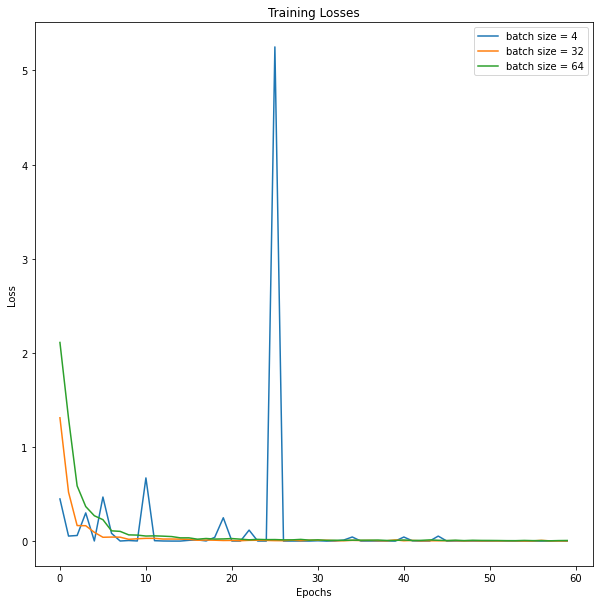

In [25]:
# Plot the training for different batch sizes
plt.figure(figsize=(10, 10))
for i in range(len(batch_sizes)):
    plt.plot(train_losses[i], label='batch size = {}'.format(batch_sizes[i]))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Losses')
plt.legend()

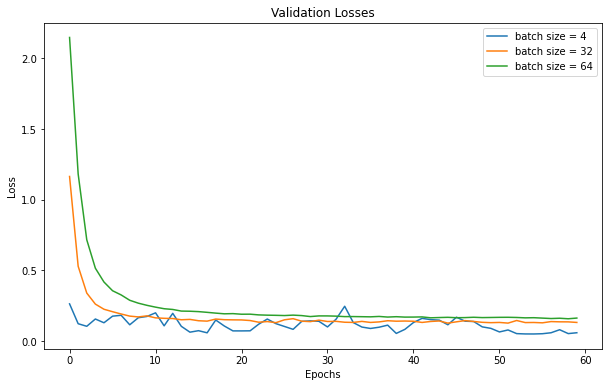

In [26]:
# Plot the validation for different batch sizes
plt.figure(figsize=(10, 6))
for i in range(len(batch_sizes)):
    plt.plot(valid_losses[i], label='batch size = {}'.format(batch_sizes[i]))
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Validation Losses')
plt.legend()

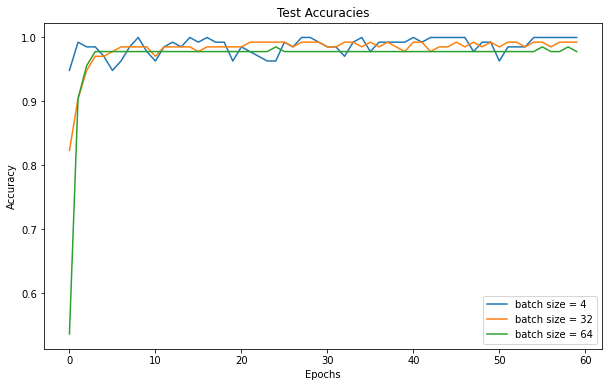

In [27]:
# Plot the test accuracy for different batch sizes
plt.figure(figsize=(10, 6))
for i in range(len(batch_sizes)):
    plt.plot(test_accs[i], label='batch size = {}'.format(batch_sizes[i]))
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Test Accuracies')
plt.legend()

In [28]:
!mkdir ResNet50_result

In [29]:
# Change the train_losses, valid_losses, test_losses, test_accs as different pandas dataframes
train_lossespd = pd.DataFrame({'batch_size_4': train_losses[0], 'batch_size_32': train_losses[1], 'batch_size_64': train_losses[2]})
valid_lossespd = pd.DataFrame({'batch_size_4': valid_losses[0], 'batch_size_32': valid_losses[1], 'batch_size_64': valid_losses[2]})
test_accspd = pd.DataFrame({'batch_size_4': test_accs[0], 'batch_size_32': test_accs[1], 'batch_size_64': test_accs[2]})

# Save the train_losses, valid_losses, test_losses, test_accs as csv files
train_lossespd.to_csv('./ResNet50_result/train_losses.csv', index=True)
valid_lossespd.to_csv('./ResNet50_result/valid_losses.csv', index=True)
test_accspd.to_csv('./ResNet50_result/test_accs.csv', index=True)